ISTA vs LISTA Algorithms

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from torch.linalg import eigvalsh 
import numpy as np
import matplotlib.pyplot as plt

Fixing the Seed of the code and datatype

In [2]:
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

Creating Dataset and plotting

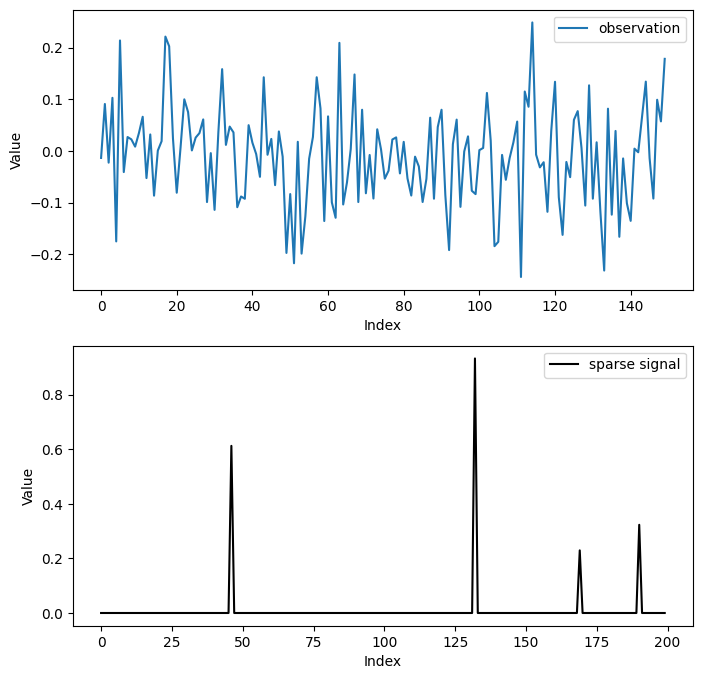

In [3]:
class SimulatedData(Data.Dataset): #Creates tuple (x, H, s) for each sample
    def __init__(self, x, H, s):
        self.x = x
        self.s = s
        self.H = H

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx, :]
        H = self.H
        s = self.s[idx, :]
        return x, H, s

def create_data_set(H, n, m, k, N=1000, batch_size=512, signal_dev=0.5, noise_dev=0.01): #function to create dataset
    # Initialization
    x = torch.zeros(N, n)
    s = torch.zeros(N, m)

    # Create signals
    for i in range(N):
        # Create a k-sparsed signal s
        index_k = np.random.choice(m, k, replace=False)
        peaks = signal_dev * np.random.randn(k)

        s[i, index_k] = torch.from_numpy(peaks).to(s)

        # X = Hs+w
        x[i, :] = H @ s[i, :] + noise_dev * torch.randn(n)

    simulated = SimulatedData(x=x, H=H, s=s)
    data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
    return data_loader

N = 1000 # number of samples
n = 150 # dim(x)
m = 200 # dim(s)
k = 4 # k-sparse signal

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

# Generate datasets
train_loader = create_data_set(H, n=n, m=m, k=k, N=N)
test_loader = create_data_set(H, n=n, m=m, k=k, N=N, batch_size=N)

x_exm, _, s_exm =test_loader.dataset.__getitem__(5)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'sparse signal', color='k')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

Training Function for LISTA

In [4]:
def train(model, train_loader, valid_loader, num_epochs=50):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))
    # Main loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):
            s_hat, _ = model.forward(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            # b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda()
            s_hat, _ = model.forward(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

ISTA Implementation

In [5]:
def ista(x, H, b_s, rho=0.5, L=1, max_itr=300):
    loss_vs_iter = np.zeros(max_itr)
    s_hat = torch.zeros(H.shape[1])
    proj = torch.nn.Softshrink(lambd=rho / L)
    for idx in range(max_itr):
        s_tild = s_hat - 1 / L * (H.T @ (H @ s_hat - x))
        s_hat = proj(s_tild)
        # Aggregate each iteration's MSE loss
        loss_vs_iter[idx] = F.mse_loss(s_hat, b_s, reduction="sum").data.item()

    return loss_vs_iter

def ista_apply(test_loader, T, H, rho=0.5):
    H = H.cpu()
    
    L = torch.abs(eigvalsh(H.T @ H)).max()

    # Aggregate T iterations' MSE loss
    losses = np.zeros((len(test_loader.dataset), T))
    for idx, (x, _, b_s) in enumerate(test_loader.dataset):
        losses[idx, :] = ista(x=x, H=H, b_s=b_s, rho=rho, L=L, max_itr=T)

    return losses.mean(axis=0)

ista_mse_vs_iter = ista_apply(test_loader, 100, H)

LISTA Class

In [6]:
class LISTA_Model(nn.Module):
    def __init__(self, n, m, L, T=6, rho=1.0, H=None):
        super(LISTA_Model, self).__init__()
        self.n, self.m = n, m
        self.H = H
        self.L = L
        self.T = T  # ISTA Iterations
        self.rho = rho  # Lagrangian Multiplier
        self.A = nn.Linear(n, m, bias=False)  # Weight Matrix
        self.B = nn.Linear(m, m, bias=False)  # Weight Matrix
        # ISTA Stepsizes eta
        self.beta = nn.Parameter(torch.ones(T + 1, 1, 1)/L, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1)/L, requires_grad=True)
        # Initialization
        if H is not None:
            self.A.weight.data = H.t()
            self.B.weight.data = H.t() @ H

        '''for param in self.A.parameters(): # A needs no_grad (should not be trained)
            param.requires_grad = False
        for param in self.B.parameters():# B needs no_grad (should not be trained)
            param.requires_grad = False'''
       
    def _shrink(self, s, beta):
        return beta * F.softshrink(s / beta, lambd=self.rho)

    def forward(self, x, s_gt=None):
        mse_vs_itr = []

        s_hat = self._shrink(self.mu[0, :, :] * self.A(x), self.beta[0, :, :])
        for i in range(1, self.T + 1):
            s_hat = self._shrink(s_hat - self.mu[i, :, :] * self.B(s_hat) + self.mu[i, :, :] * self.A(x),
                                 self.beta[i, :, :], )
            
            # Aggregate each iteration's MSE loss
            if s_gt is not None:
                mse_vs_itr.append(F.mse_loss(s_hat.detach(), s_gt.detach(), reduction="sum").data.item())

        return s_hat, mse_vs_itr
  

LISTA Implementation(Untrained)

In [7]:
# Untrained LISTA implementation
def lista_untrained_apply(test_loader, T, H):
    n = H.shape[0]
    m = H.shape[1]
    L = torch.abs(eigvalsh(H.T @ H)).max()
    lista_untrained = LISTA_Model(n=n, m=m, L=L, T=T, rho=.5, H=H)
    # not trainig the model
    s_gt, x = test_loader.dataset.s, test_loader.dataset.x
    _, mse_vs_iter = lista_untrained(x, s_gt=s_gt)
    return np.array(mse_vs_iter) / len(test_loader.dataset)

lista_untrained_mse_vs_iter = lista_untrained_apply(test_loader, 100, H)

LISTA Implementation(Trained)

In [8]:
  
def lista_apply(train_loader, test_loader, T, H):
    n = H.shape[0]
    m = H.shape[1]
    L=torch.abs(eigvalsh(H.T @ H)).max()
    lista = LISTA_Model(n=n, m=m, L=L, T=T, rho=.8, H=H)
    train(lista, train_loader, test_loader)
    
    # Extract all samples and calculate MSE for each iteration
    s_gt, x = test_loader.dataset.s, test_loader.dataset.x
    _, mse_vs_iter = lista(x, s_gt=s_gt)

    return np.array(mse_vs_iter)/len(test_loader.dataset)

lista_mse_vs_iter = lista_apply(train_loader, test_loader, 5, H)
print(lista_mse_vs_iter)

Epoch 0, Train loss 0.80966405, Validation loss 0.66523310
Epoch 10, Train loss 0.05265499, Validation loss 0.04831604
Epoch 20, Train loss 0.01123904, Validation loss 0.01190859
Epoch 30, Train loss 0.00259860, Validation loss 0.00311740
Epoch 40, Train loss 0.00154395, Validation loss 0.00207738
[0.4044388  0.34953953 0.1581561  0.03159155 0.00185842]


plotting just ista

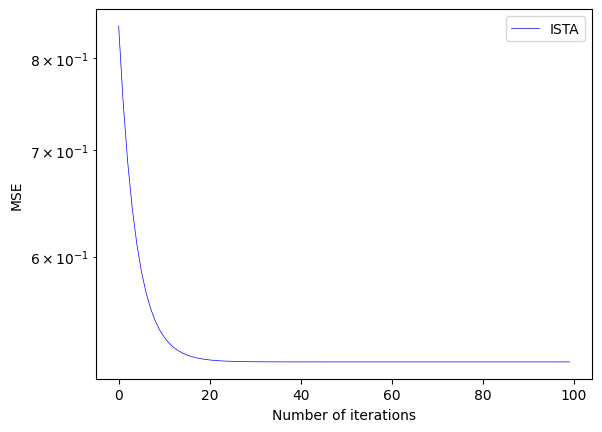

In [9]:
fig = plt.figure()
plt.plot(range(100), ista_mse_vs_iter, label='ISTA', color='b', linewidth=0.5)
plt.xlabel('Number of iterations', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.yscale("log")
plt.legend()
plt.show()

Plotting the ista vs untrained lista Results

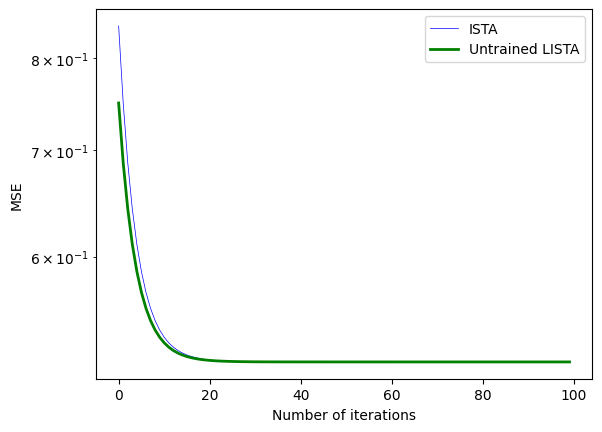

In [10]:
fig = plt.figure()
plt.plot(range(100), ista_mse_vs_iter, label='ISTA', color='b', linewidth=0.5)
plt.plot(range(100), lista_untrained_mse_vs_iter, label='Untrained LISTA', color='g', linewidth=2)
plt.xlabel('Number of iterations', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.yscale("log")
plt.legend()
plt.show()

Plotting the ista vs trained lista Results

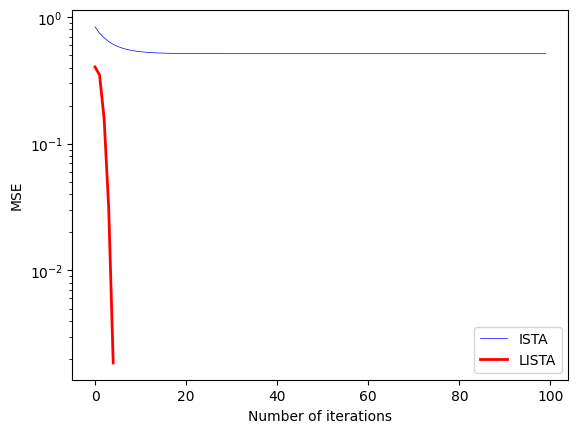

In [11]:
fig = plt.figure()
plt.plot(range(100), ista_mse_vs_iter, label='ISTA', color='b', linewidth=0.5)
plt.plot(range(5), lista_mse_vs_iter, label='LISTA', color='r', linewidth=2)
plt.xlabel('Number of iterations', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.yscale("log")
plt.legend()
plt.show()